<a href="https://colab.research.google.com/github/DaryaTereshchenko/HateSpeechDetection/blob/main/Embedding_hurtlex_EN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentence_transformers
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [37]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, TextVectorization, Input

In [4]:
ethos_hate = pd.read_csv("ethos_hate.csv", sep=",", encoding="unicode_escape").drop(columns="label")
ethos_hate["label"] = 1

ethos_neutral = pd.read_csv("ethos_neutral.csv", sep=",", encoding="unicode_escape").drop(columns="label")
ethos_neutral["label"] = 0

train_n = ethos_neutral.sample(frac=0.9, random_state=0)
test_n = ethos_neutral.drop(train_n.index)

train_hate = ethos_hate.sample(frac=0.9, random_state=0)
test_hate = ethos_hate.drop(train_hate.index)


train = pd.concat([train_n, train_hate]).sample(frac=1, random_state=300).reset_index(drop=True)
test = pd.concat([test_n, test_hate]).sample(frac=1, random_state=300).reset_index(drop=True)

print(train.text[0])


What episode number was this?


In [5]:
hate_speech = pd.read_csv('ethos_sm_hate.csv', sep=";", decimal=",", skiprows=[1,2,3,4], low_memory=False, on_bad_lines='skip').sort_values(by=["CODE"])
neutral_speech = pd.read_csv('ethos_sm_neutral.csv', sep=";", decimal=",", skiprows=[1,2,3,4], low_memory=False, on_bad_lines='skip').sort_values(by=["CODE"])

hate_speech = hate_speech.drop(columns="CODE")
neutral_speech = neutral_speech.drop(columns="CODE")

In [6]:
train_sm_n = neutral_speech.sample(frac=0.9, random_state=0)
test_sm_n = neutral_speech.drop(train_sm_n.index)

train_sm_hate = hate_speech.sample(frac=0.9, random_state=0)
test_sm_hate = hate_speech.drop(train_sm_hate.index)

TrainSM = pd.concat([train_sm_n, train_sm_hate]).sample(frac=1, random_state=300).reset_index(drop=True)
TestSM = pd.concat([test_sm_n, test_sm_hate]).sample(frac=1, random_state=300).reset_index(drop=True)

In [7]:
def clean_text(line):
  processed_line = line.lower()
  words = [word for word in word_tokenize(processed_line)]
  processed_line = [word for word in words if word not in set(string.punctuation)]
  text = " ".join(processed_line)
  return text

In [49]:
# Sentences for embeddings
train_sentence_list = np.asarray(list((map(clean_text, train.text.values))))
test_sentence_list = np.asarray(list(map(clean_text, test.text.values)))

In [38]:

y_train = np.asarray(train.label, dtype='int32').reshape(-1,1)
y_test = np.asarray(test.label, dtype='int32').reshape(-1,1)

In [20]:
df = pd.read_csv('hurtlex_EN.tsv', sep='\t')

In [22]:
inclusive = df.loc[df["level"] == "inclusive", "lemma"]

In [23]:
df

,id,pos,category,stereotype,lemma,level
0,EN1382,n,qas,no,gag reel,inclusive
1,EN7077,a,cds,no,snotty,conservative
2,EN6856,n,is,yes,mendicant,conservative
3,EN5485,n,re,no,maffias,conservative
4,EN5024,n,cds,no,lying in trade,conservative
...,...,...,...,...,...,...
8223,EN7899,n,an,no,perosuchus,inclusive
8224,EN1319,n,cds,no,mother fucka,conservative
8225,EN2597,n,cds,no,refuse,conservative
8226,EN521,n,asm,no,simple,inclusive


In [34]:
vocab = df["lemma"].unique()

In [35]:
vocab

array(['gag reel', 'snotty', 'mendicant', ..., 'egoistic', 'perosuchus',
       'stubborn'], dtype=object)

In [72]:
MAX_LEN = 128
max_features = 10000  # maximum word number
embedding_dims = 2

In [ ]:
input = Input(shape=(), dtype=tf.string)
vectorize_layer = TextVectorization(max_tokens=max_features, output_mode='int', output_sequence_length=MAX_LEN, vocabulary=vocab)(input)
emb =  Embedding(input_dim=max_features, output_dim=20, input_length=MAX_LEN)(vectorize_layer)
model = Model(inputs=input, outputs=emb)
model.predict(test_sentence_list)

In [103]:
def build_model():
  input = Input(shape=(), dtype=tf.string)
  np_sm = Input(shape=(157,), dtype=tf.float32, name='np_sm')

  vectorize_layer = TextVectorization(max_tokens=max_features, output_mode='int', output_sequence_length=MAX_LEN, vocabulary=vocab)(input)
  x = Embedding(input_dim=max_features, output_dim=20, input_length=MAX_LEN)(vectorize_layer)
  # x = tf.keras.layers.Conv1D(128, 10, activation='relu')(x)
  x = tf.keras.layers.Dropout(rate=0.5)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.concatenate([x, np_sm])
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = Model(inputs=[input, np_sm], outputs=x)

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
      loss= tf.keras.losses.binary_crossentropy,
      metrics=['accuracy'])
  
  return model


Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 text_vectorization_24 (TextVec  (None, 128)         0           ['input_24[0][0]']               
 torization)                                                                                      
                                                                                                  
 embedding_18 (Embedding)       (None, 128, 20)      200000      ['text_vectorization_24[0][0]']  
                                                                                                  
 dropout_18 (Dropout)           (None, 128, 20)      0           ['embedding_18[0][0]']    

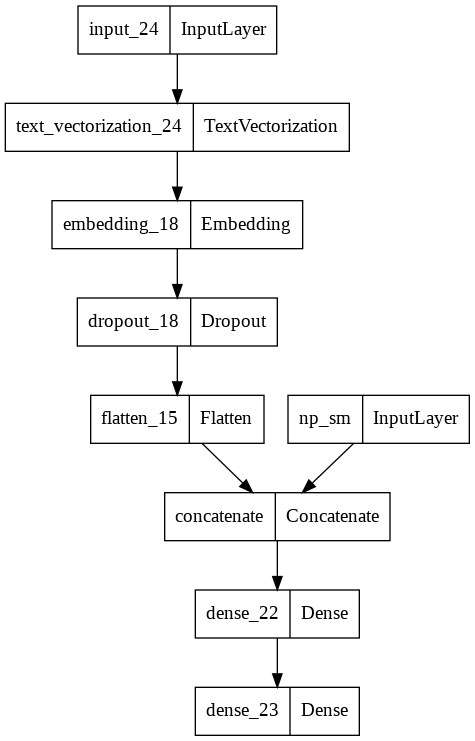

In [104]:
model = build_model()
model.summary()
tf.keras.utils.plot_model(model)

In [105]:

print('Training...')
history = model.fit([train_sentence_list, np.asarray(TrainSM.values, dtype="float32")],
                    y_train,
                    epochs=5,
                    batch_size=16,
                    verbose=1,
                    validation_data=([test_sentence_list, np.asarray(TestSM.values, dtype="float32")], y_test))
     

Training...
Epoch 1/5
57/57 [==============================] - 1s 13ms/step - loss: 0.6907 - accuracy: 0.5501 - val_loss: 0.6919 - val_accuracy: 0.5500
Epoch 2/5
57/57 [==============================] - 0s 8ms/step - loss: 0.6872 - accuracy: 0.5646 - val_loss: 0.6907 - val_accuracy: 0.5700
Epoch 3/5
57/57 [==============================] - 1s 9ms/step - loss: 0.6879 - accuracy: 0.5635 - val_loss: 0.6901 - val_accuracy: 0.5700
Epoch 4/5
57/57 [==============================] - 1s 10ms/step - loss: 0.6854 - accuracy: 0.5646 - val_loss: 0.6894 - val_accuracy: 0.5700
Epoch 5/5
57/57 [==============================] - 1s 11ms/step - loss: 0.6860 - accuracy: 0.5657 - val_loss: 0.6889 - val_accuracy: 0.5700


In [107]:
y_pred = [int(np.round(i,0)) for i in model.predict([test_sentence_list, np.asarray(TestSM.values, dtype="float32")])]

4/4 [==============================] - 0s 4ms/step


In [108]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      1.00      0.73        57
           1       0.00      0.00      0.00        43

    accuracy                           0.57       100
   macro avg       0.28      0.50      0.36       100
weighted avg       0.32      0.57      0.41       100



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
